# ПРОГНОЗНАЯ МОДЕЛЬ ТЕМПЕРАТУРЫ ВОЗДУХА ДЛЯ МЕТЕОСТАНЦИИ МАГАДАН

> **ДИСКЛЕЙМЕР:** не претендую на абсолютную правильность обучения модели и точность прогнозируемых данных. Пробую и исследую новое для себя направление :) 

**ЦЕЛЬ** -  построить и обучить модель машинного обучения (Machine Learning) прогнозировать временные ряды по фактическим данным (температура воздуха).

**Задачи:**
- подготовить данные
- рассчитать скользящее среднее за 12 месяцев
- разложить временной ряд на компоненты и выявить наличие/отсутствие тренда и сезонности
- проверить гипотезу на стационарность/нестационарность процесса
- выполнить автокорреляцию данных
- выполнить прогноз с помощью экспоненциального сглаживания
- выполнить прогноз с помощью модели ARMA

Работать будем с датасетом, который содержит среднемесячные температуры воздуха м/с Магадан с 1993 по 2022 гг. (30 лет). Источник -  http://www.pogodaiklimat.ru/.


## Подготовка данных

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# датасет с временным рядом
data = pd.read_excel(r'E:\2023\прогноз\magadan_temp.xlsx') 

# выведем первые 5 строк
data.head() 

,date,temp
0,1933-01-01,-25.0
1,1933-02-01,-19.6
2,1933-03-01,-11.6
3,1933-04-01,-6.1
4,1933-05-01,2.1


In [3]:
# превратим дату в объект datetime
data.index = pd.to_datetime(data['date'])
 
# посмотрим на первые пять дат и на тип данных
data.index[:5]

DatetimeIndex(['1933-01-01', '1933-02-01', '1933-03-01', '1933-04-01',
               '1933-05-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [4]:
# дату перенесем в индекс
data.set_index('date', inplace = True)

# выведем первые 5 строк
data.head()

,temp
date,
1933-01-01,-25.0
1933-02-01,-19.6
1933-03-01,-11.6
1933-04-01,-6.1
1933-05-01,2.1


In [5]:
# оставим в датасете данные за последние 30 лет
data = data.query('date >= "1993-01"')

# выведем первые 5 строк
data.head()

,temp
date,
1993-01-01,-19.4
1993-02-01,-12.6
1993-03-01,-12.6
1993-04-01,-4.5
1993-05-01,2.3


<div class="alert alert-info">
    
**📝 Комментарий Маши**
      
Преобразование даты в индекс позволит сократить код для дальнейших действий. 
     
Сокращение временного ряда до 30 последних лет сделает визуализацию проще и нагляднее. В дальнейшем оставим временной ряд полным.
 
</div>

## Расчет скользящего среднего

Построим график временного ряда температуры воздуха в Магадане с 1993 по 2022 гг.

[Text(0.5, 1.0, 'Температура воздуха в Магадане с 1993 по 2022 гг.'),
 Text(0.5, 0, 'Месяцы'),
 Text(0, 0.5, 'Температура')]

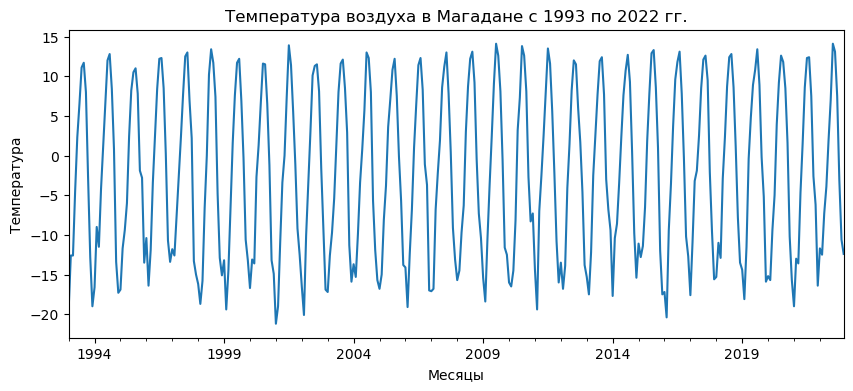

In [6]:
# построим график
ax = data.plot(figsize = (10,4), legend = None)
ax.set(title = 'Температура воздуха в Магадане с 1993 по 2022 гг.', xlabel = 'Месяцы', ylabel = 'Температура')

Рассчитаем скользящее среднее за 1 год для наших данных. Период, за который рассчитывается скользящее среднее, также называется окном (window).

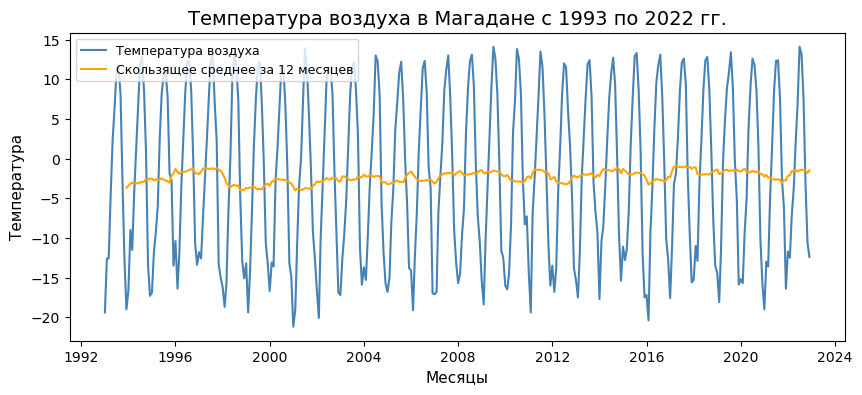

In [7]:
# зададим размер графика
plt.figure(figsize = (10,4))
 
# поочередно зададим кривые (температуры и скользящее среднее) с подписями и цветом
plt.plot(data, label = 'Температура воздуха', color = 'steelblue')
plt.plot(data.rolling(window = 12).mean(), label = 'Скользящее среднее за 12 месяцев', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 9)
 
# добавим подписи к осям и заголовки
plt.xlabel('Месяцы', fontsize = 11)
plt.ylabel('Температура', fontsize = 11)
plt.title('Температура воздуха в Магадане с 1993 по 2022 гг.', fontsize = 14)
 
# выведем обе кривые на одном графике
plt.show()

<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Скользящее среднее сглаживает показатели и позволяет отследить тенденцию. Так как в данном случае мы взяли окно равное двенадцати месяцам, то первое значение скользящего среднего мы получили только за декабрь 1993 года.

    
</div>

## Разложение временного ряда на компоненты

Выявление компонентов временного ряда (time series decomposition) предполагает его разложение на тренд, сезонность и случайные колебания. 

- Тренд — долгосрочное изменение уровня ряда
- Сезонность предполагает циклические изменения уровня ряда с постоянным периодом
- Случайные колебания — непрогнозируемое случайное изменение ряда

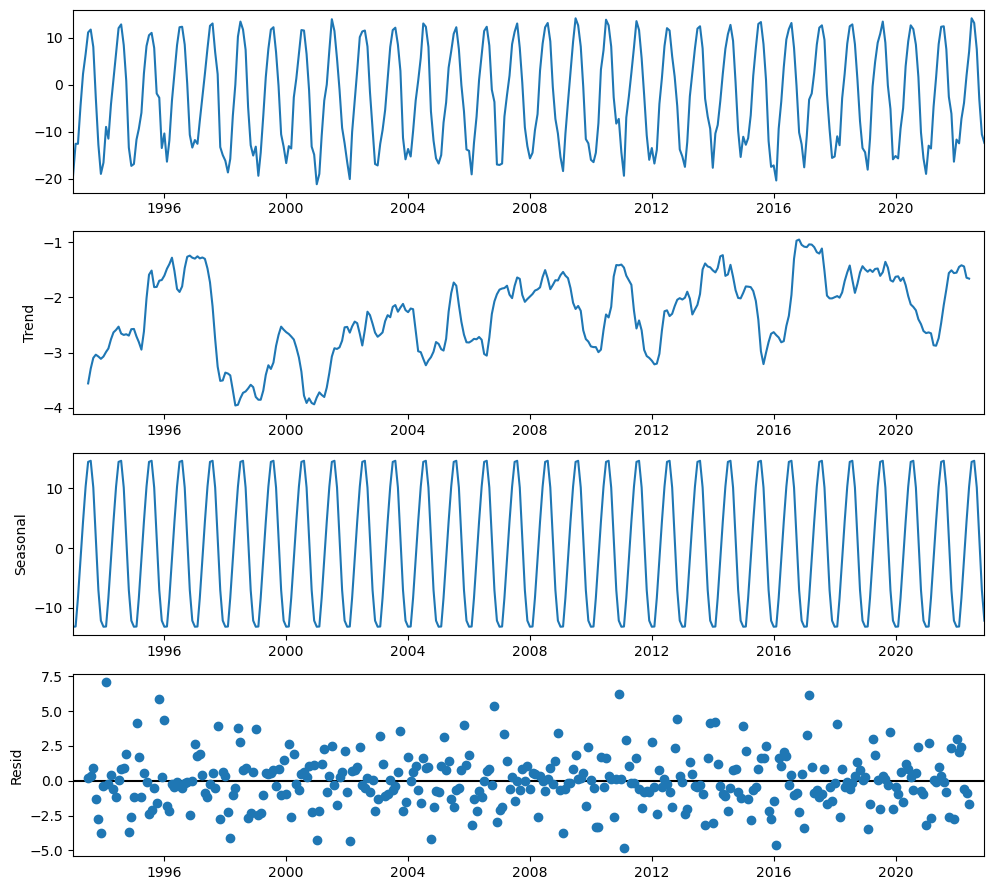

In [8]:
# импортируем функцию seasonal_decompose из statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
 
# задаем размер графика
from pylab import rcParams
rcParams['figure.figsize'] = 10, 9
 
# применяем функцию к температурам
decompose = seasonal_decompose(data)
decompose.plot()
 
plt.show()

<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Датасет демонстрирует очевидную сезонность, а наличие четкого тренда выделить нельзя.
    
</div>

## Проверка гипотезы на стационарность процесса

Стационарность (stationarity) временного ряда как раз означает, что такие компоненты как тренд и сезонность отсутствуют. Говоря более точно, среднее значение и дисперсия не меняются со смещением во времени.

Понимание того, стационарные ли у нас данные или нестационарные важно для последующего моделирования. Для более точной оценки стационарности можно применить тест Дики-Фуллера (Dickey-Fuller test). 

В данном случае гипотезы звучат следующим образом:

***Нулевая гипотеза*** - процесс нестационарный.

***Альтернативная гипотеза*** - процесс стационарный (отвергает нулевую гипотезу).

Применим этот тест к обоим датасетам. Используем пороговое значение, равное 0,05 (5%).

In [9]:
# импортируем необходимую функцию 
from statsmodels.tsa.stattools import adfuller
 
# передадим ей столбец с данными о температурах и поместим результат в adf_test
adf_test = adfuller(data['temp'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.003902351365668204


<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Как мы видим, вероятность (p-value) для данных меньше 0,05. Мы отвергаем нулевую гипотезу. Процесс станионарный. 
    
</div>

## Автокорреляция данных

Корреляция показывает силу взаимосвязи двух переменных и позволяет строить модель. Автокорреляция также показывает степень взаимосвязи в диапазоне от –1 до 1, но только не двух переменных, а одной и той же переменной в разные моменты времени.

Автокорреляцию удобно вычислить и изобразить с помощью графика автокорреляционной функции (autocorrelation function, ACF). Построим график ACF для наших данных.

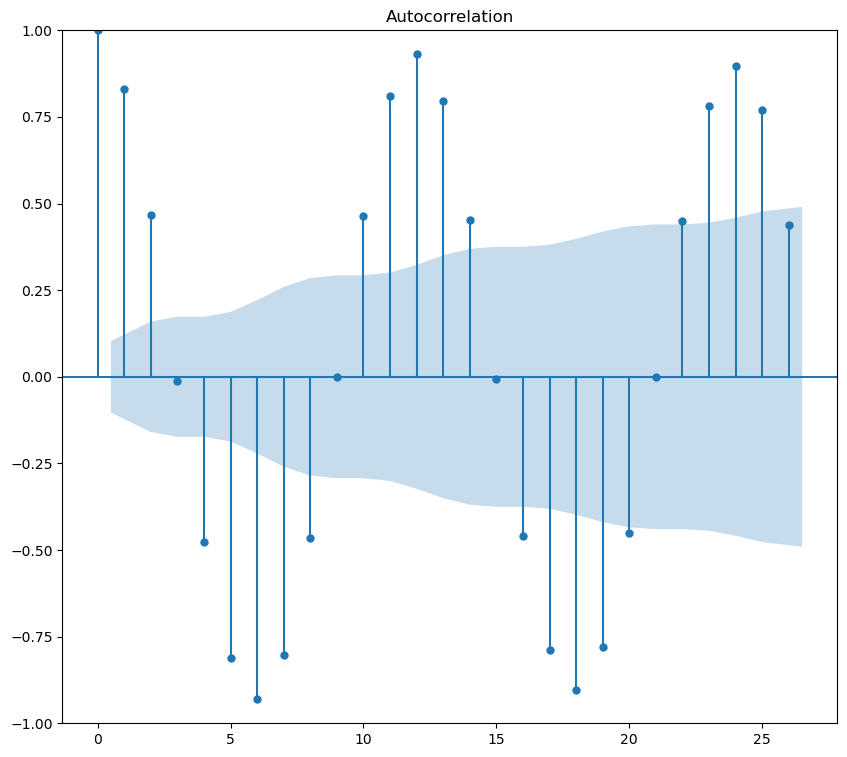

In [10]:
# импортируем функцию для построения автокорреляционной функции (ACF)
from statsmodels.graphics.tsaplots import plot_acf
 
# применим ее к данным о температурах
plot_acf(data)
plt.show()

<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Автокорреляция позволяет выявлять тренд и сезонность, а также используется при подборе параметров моделей. В частности, мы видим, что некоторые лаги сильнее коррелируют с исходным рядом, чем соседние. Такая автокорреляция позволяет предположить наличие (ежегодных) сезонных колебаний.

Если бы корреляция была постоянно положительной, то это бы говорило о наличии тренда. Все это согласуется с тем, что мы узнали о данных, когда раскладывали их на компоненты.

Синяя граница позволяет оценить статистическую значимость корреляции. Если столбец выходит за ее пределы, то автокорреляция достаточно сильна и ее можно использовать при построении модели.
    
</div>

## Прогноз с помощью экспоненциального сглаживания

Вновь обратимся к скользящему среднему (см. выше). В этой модели всем предыдущим наблюдениям задавался одинаковый вес и количество таких наблюдений было ограничено (размер окна - 12 месяцев).

Однако логично предположить, что недавние наблюдения более важны для прогноза, чем более отдаленные. Кроме того, мы можем взять все, а не некоторые из имеющихся у нас наблюдений.

В модели экспоненциального сглаживания (exponential smoothing) или экспоненциального скользящего среднего мы как раз (1) берем все предыдущие значения и (2) задаем каждому из наблюдений определенный вес и (экспоненциально) уменьшаем этот вес по мере углубления в прошлое.

Как мы видим, прогнозное значение зависит как от истинного, так и от прогнозного значений. Важность этих значений определяется параметром альфа, который варьируется от 0 до 1. Чем альфа больше, тем больший вес у истинного наблюдения.

Формула рекурсивна, т.е. каждый раз мы умножаем (1 – α) на очередное прогнозное значение и так до конца временного ряда.

In [11]:
# создадим копию датафрейма для работы
exp_data = data.copy()

In [12]:
alpha = 0.2
 
# первое значение совпадает со значением временного ряда
exp_smoothing = [exp_data['temp'][0]]
 
# в цикле for последовательно применяем формулу ко всем элементам ряда
for i in range(1, len(exp_data['temp'])):
  exp_smoothing.append(alpha * exp_data['temp'][i] + (1 - alpha) * exp_smoothing[i - 1])
 
# выведем прогнозное значение для 13 месяца (январь 2023)
exp_smoothing[-1]

-2.3491636907339895

In [13]:
# выявляем кол-во натурных наблюдений и кол-во прогнозных значений
len(exp_data), len(exp_smoothing)

(360, 360)

<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Для временного ряда, состоящего из 360 наблюдений (1993-2022 гг.), мы получим 360 прогнозных значений (вплоть до января 2023 года включительно).
    
</div>

Теперь добавим эти данные в нашу копию датафрейма, с которым будем работать для построение прогноза по экспоненциальной кривой.

In [14]:
# добавим кривую сглаживания в качестве столбца в датафрейм
exp_data['exp_smoothing'] = exp_smoothing

exp_data.tail(3)

,temp,exp_smoothing
date,,
2022-10-01,-3.1,2.854432
2022-11-01,-10.6,0.163545
2022-12-01,-12.4,-2.349164


<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Так как фактические значения описывают период с января 1993 г. по декабрь 2022 г., а прогнозные с февраля 1993 г. по январь 2023 г., мы не можем просто их соединить. Второй столбец нужно сдвинуть на один месяц вперед.
    
</div>

In [15]:
# импортируем класс timedelta
from datetime import timedelta

# возьмём последний индекс (декабрь 2022 года)
last_date = exp_data.iloc[[-1]].index
 
# # "прибавим" один месяц (31 день)
last_date = last_date + timedelta(days = 31)
last_date
 
# добавим его в датафрейм
exp_data = exp_data.append(pd.DataFrame(index = last_date))
 
# значения за этот день останутся пустыми
exp_data.tail()

C:\Users\Maria\AppData\Local\Temp\ipykernel_9264\2475632651.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  exp_data = exp_data.append(pd.DataFrame(index = last_date))


,temp,exp_smoothing
date,,
2022-09-01,7.5,4.343040
2022-10-01,-3.1,2.854432
2022-11-01,-10.6,0.163545
2022-12-01,-12.4,-2.349164
2023-01-01,NaN,NaN


Сдвинем второй столбец.

In [16]:
# сдвинем второй столбец
exp_data['exp_smoothing'] = exp_data['exp_smoothing'].shift(1)

И посмотрим на начало и конец датафрейма.

In [17]:
# посмотрим 5 первых строк, как и должно быть первое прогнозное значение совпадает с предыдущим фактическим
exp_data.head()

,temp,exp_smoothing
date,,
1993-01-01,-19.4,NaN
1993-02-01,-12.6,-19.4000
1993-03-01,-12.6,-18.0400
1993-04-01,-4.5,-16.9520
1993-05-01,2.3,-14.4616


In [18]:
# посмотрим 5 последних строк, и у нас есть прогноз на один месяц вперед
exp_data.tail()

,temp,exp_smoothing
date,,
2022-09-01,7.5,3.553800
2022-10-01,-3.1,4.343040
2022-11-01,-10.6,2.854432
2022-12-01,-12.4,0.163545
2023-01-01,NaN,-2.349164


Теперь выведем фактические и прогнозные значения на графике.

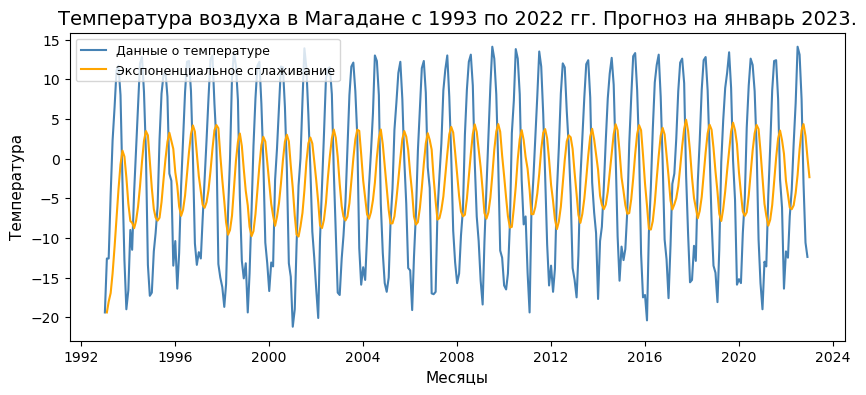

In [19]:
# зададим размер
plt.figure(figsize = (10,4))
 
# выведем данные о температуре и кривую экспоненциального сглаживания
plt.plot(exp_data['temp'], label = 'Данные о температуре', color = 'steelblue')
plt.plot(exp_data['exp_smoothing'], label = 'Экспоненциальное сглаживание', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 9)
 
# добавим подписи к осям и заголовки
plt.ylabel('Температура', fontsize = 11)
plt.xlabel('Месяцы', fontsize = 11)
plt.title('Температура воздуха в Магадане с 1993 по 2022 гг. Прогноз на январь 2023.', fontsize = 14)
 
plt.show()

<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Модель экспоненциального сглаживания можно усложнить и тогда она будет улавливать тренд и сезонность. Кроме того, усложненные модели способны предсказывать более одного значения (здесь мы смогли сделать прогноз лишь на один месяц вперёд).
    
</div>

## Прогноз с помощью модели ARMA

Модель ARMA состоит из двух компонентов.

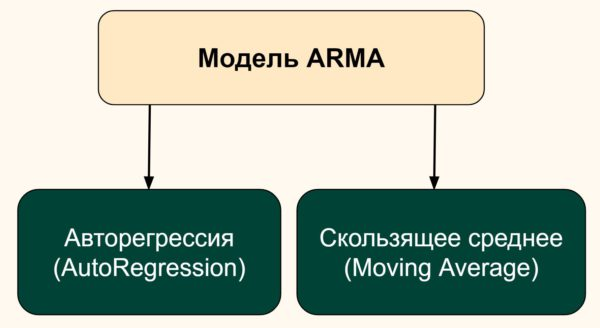

Авторегрессия (autoregressive model, AR) — это регрессия ряда на собственные значения в прошлом. Другими словами, наши признаки в модели обычной регрессии мы заменяем значениями той же переменной, но за предыдущие периоды.

Модель скользящего среднего (moving average, MA) помогает учесть случайные колебания или отклонения (ошибки) истинного значения от прогнозного. Можно также сказать, что модель скользящего среднего — это авторегрессия на ошибку.

Обратите внимание, что скользящее среднее временного ряда, которое мы рассмотрели выше, и модель скользящего среднего — это разные понятия.

ARMA предполагает, что в данных отсутствует тренд и сезонность (данные стационарны). Если данные нестационарны или сезонны, нужно использовать более сложные версии этих моделей:

ARIMA, здесь добавляется компонент Integrated (I), который отвечает за удаление тренда (сам процесс называется дифференцированием); и
SARIMA, эта модель учитывает сезонность (Seasonality, S)
SARIMAX включает еще и внешние или экзогенные факторы (eXogenous factors, отсюда и буква X в названии), которые напрямую не учитываются моделью, но влияют на нее.

Воспользуемся моделью SARIMAX для прогнозирования температуры.

Для получения корректного прогноза необходимо достаточное количество данных о предыдущих значениях температуры. Важно учитывать, что совсем старые данные не могут быть использованы, иначе прогноз будет недостоверным. Кроме того, чем больший интервал прогноза будет рассматриваться, тем больше данных потребуется.

In [20]:
# создадим копию датафрейма для работы
model_data = data. copy ()

Разбиваем данные на обучающую и тестовую выборки.

In [21]:
# обучающая выборка будет включать данные до декабря 2021 года включительно
train = model_data['1993-01':'2021-12']
 
# тестовая выборка начнется с января 2022 года (по сути, один год)
test = model_data['2022-01':]

Посмотрим на разделение на графике.

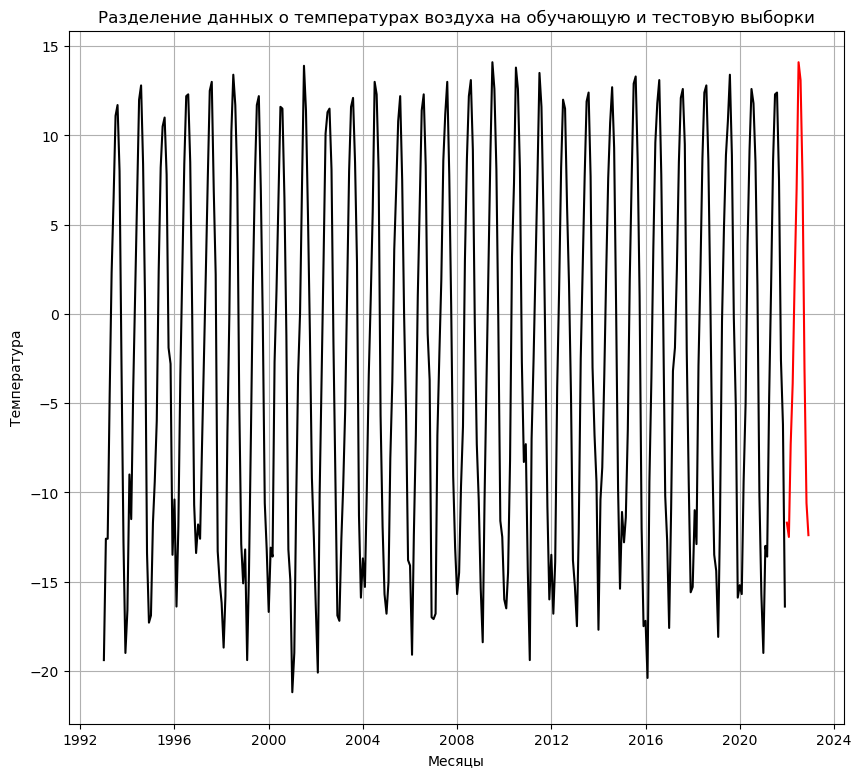

In [22]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
 
# заголовок и подписи к осям
plt.title('Разделение данных о температурах воздуха на обучающую и тестовую выборки')
plt.ylabel('Температура')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Далее нам нужно обучить модель. При обучении модели SARIMAX, самое важное — правильно подобрать гиперпараметры, о которых говорилось выше. 
    
</div>

Т.к. процесс подбора параметров модели довольно долгий и затормаживающий процесс, оставим это вне проекта и возьмем уже готовые, вычисленные мною. Обучим модель с соответствующими параметрами, SARIMAX(1, 0, 0)x(2, 1, 0, 12)

In [23]:
# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# создадим объект этой модели
model = SARIMAX(train, 
                order = (1, 0, 0), 
                seasonal_order = (2, 1, 0, 12))
 
# применим метод fit
result = model.fit()

C:\Users\Maria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Maria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Вначале сделаем тестовый прогноз, соответствующий периоду тестовой выборки (2022 г.), для того, чтобы оценить качество работы модели.

In [24]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions = result.predict(start, end)
predictions

2022-01-01   -16.304421
2022-02-01   -15.865753
2022-03-01   -11.617664
2022-04-01    -2.995360
2022-05-01     3.506986
2022-06-01     8.883827
2022-07-01    11.756998
2022-08-01    12.655793
2022-09-01     8.346660
2022-10-01    -0.488586
2022-11-01    -6.846960
2022-12-01   -16.006587
Freq: MS, Name: predicted_mean, dtype: float64

Построим соответствующий график.

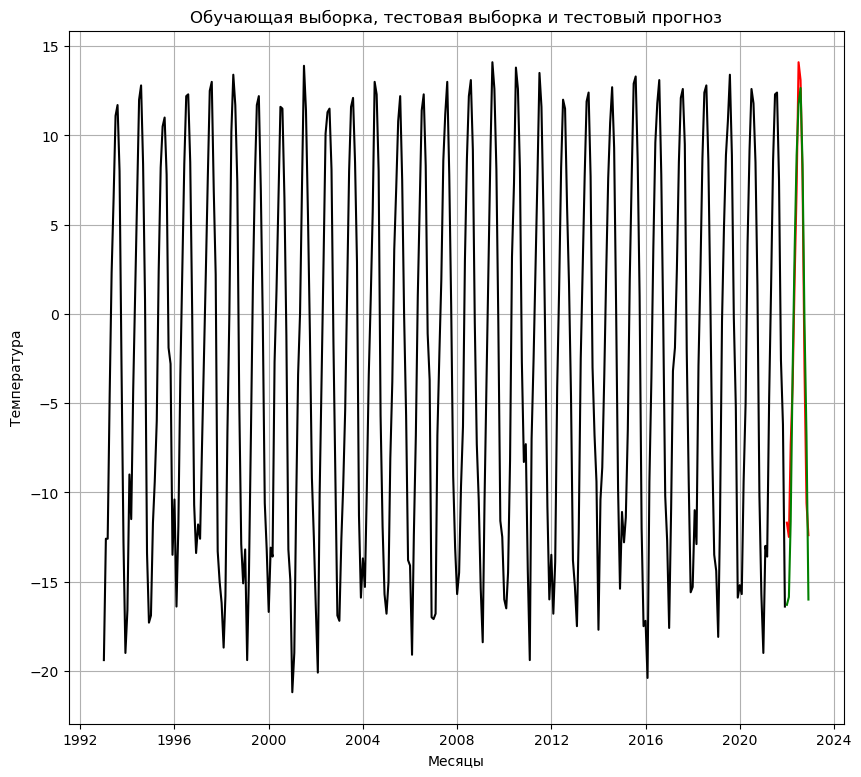

In [25]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(predictions, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Температура')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
В целом модель хорошо описывает временной ряд. Мы также можем использовать знакомые нам метрики среднеквадратической ошибки (MSE) и корня среднеквадратической ошибки (RMSE) для оценки качества.
    
</div>

In [26]:
# импортируем метрику
from sklearn.metrics import mean_squared_error
 
# рассчитаем MSE
print(mean_squared_error(test, predictions))
 
# и RMSE
print(np.sqrt(mean_squared_error(test, predictions)))

8.203072218956875
2.864100595118278


<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Среднеквадратическая ошибка MSE равна 8.2. Это говорит нам о том, что среднеквадратическая разница между предсказанными значениями, сделанными моделью, и фактическими значениями составляет 8.2.

Среднеквадратическая ошибка RMSE равна 2.86. Это говорит нам о том, что среднее отклонение между прогнозируемыми набранными баллами и фактическими набранными баллами равно 2.86.

На практике мы обычно подгоняем несколько моделей регрессии к набору данных и вычисляем среднеквадратичную ошибку (RMSE) каждой модели.

Затем мы выбираем модель с самым низким значением RMSE в качестве «лучшей» модели, потому что именно она делает прогнозы, наиболее близкие к фактическим значениям из набора данных.

Обратите внимание, что мы также можем сравнивать значения MSE каждой модели, но RMSE проще интерпретировать, поэтому он используется чаще.
    
</div>

Теперь можно делать прогноз на будущее. Возьмём горизонт равный трем годам (2023, 2024 и 2025 гг.). Всего должно получиться 36 прогнозных значений.

In [27]:
# прогнозный период с конца имеющихся данных
start = len(model_data)
 
# и закончится 36 месяцев спустя
end = (len(model_data) - 1) + 3 * 12
 
# теперь построим прогноз на три года вперед
forecast = result.predict(start, end)
 
# посмотрим на весь прогноз на 2023-2025 гг.
forecast

2023-01-01   -16.561691
2023-02-01   -15.036046
2023-03-01   -11.223446
2023-04-01    -4.280102
2023-05-01     3.137241
2023-06-01     8.939711
2023-07-01    12.251107
2023-08-01    12.232634
2023-09-01     8.185510
2023-10-01    -0.182221
2023-11-01    -8.067040
2023-12-01   -15.983779
2024-01-01   -17.505532
2024-02-01   -14.411177
2024-03-01   -12.314632
2024-04-01    -4.113284
2024-05-01     2.555790
2024-06-01     8.783858
2024-07-01    12.140209
2024-08-01    12.414464
2024-09-01     7.943741
2024-10-01    -1.267194
2024-11-01    -6.968075
2024-12-01   -16.162610
2025-01-01   -16.756342
2025-02-01   -15.180889
2025-03-01   -11.735591
2025-04-01    -3.693523
2025-05-01     3.105019
2025-06-01     8.866737
2025-07-01    12.010582
2025-08-01    12.466362
2025-09-01     8.175188
2025-10-01    -0.655913
2025-11-01    -7.209592
2025-12-01   -16.050362
Freq: MS, Name: predicted_mean, dtype: float64

Посмотрим на прогнозные значения на графике.

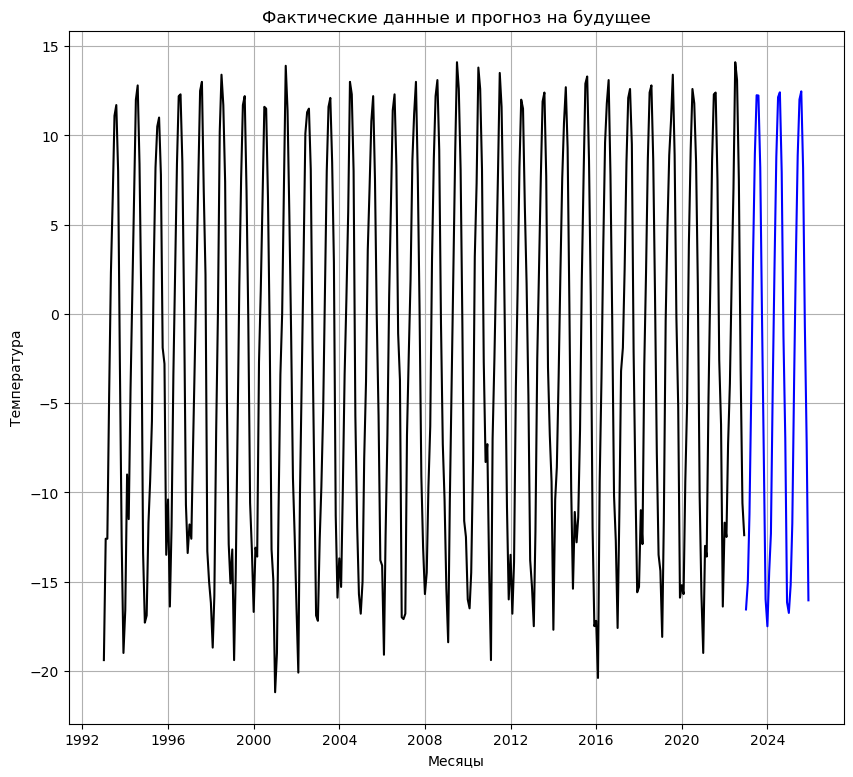

In [28]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(model_data, color = 'black')
plt.plot(forecast, color = 'blue')
 
# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Температура')
plt.xlabel('Месяцы')
 
# добавим сетку
plt.grid()
 
plt.show()

<div class="alert alert-info">
    
**📝 Комментарий Маши**
    
Благодаря обученной модели получили прогнозные значения температуры воздуха на 3 года вперед (2023-2025 гг.). 
    
    
</div>

## Выводы

Для построения и обучения модели машинного обучения (Machine Learning) прогнозировать временные ряды был использован датасет, который содержит среднемесячные температуры воздуха м/с Магадан с 1993 по 2022 гг. (за 30 лет).

Данные демонстрируют очевидную сезонность без наличия четкого тренда. Процесс станионарный.

Модель экспоненциального сглаживания предсказала температуру на месяц вперед (январь 2023 г.), которая составила -2.34 градусов.

Далее построили и обучили модель SARIMAX для прогнозирования температуры. Для получения корректного прогноза необходимо достаточное количество данных о предыдущих значениях температуры, но совсем старые данные не могут быть использованы, иначе прогноз будет недостоверным. У нас были данные за 30 лет (с 1993 г.).

В целом модель хорошо описывает временной ряд. 

Для оценки качества модели выявили следующие метрики: среднеквадратическая разница между предсказанными значениями, сделанными моделью, и фактическими значениями составляет 8.2; среднее отклонение между прогнозируемыми набранными баллами и фактическими набранными баллами равно 2.86.

Получили прогноз на 3 года вперед (2023, 2024 и 2025 гг.). Всего получили 36 прогнозных значений.

### Литература


1. https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/
2. https://codecamp.ru/blog/mse-vs-rmse/
3. https://dmitrymakarov.ru/intro/time-serie
4. https://habr.com/ru/companies/ods/articles/327242/
5. https://loginom.ru/blog/arima-example
6. https://machinelearningmastery.ru/sarima-for-time-series-forecasting-in-python/
7. https://otexts.com/fpp2/arima.html
8. https://pythobyte.com/using-machine-learning-to-predict-the-weather-part-1-6ce3963b/
9. https://studfile.net/preview/4179777/page:2/
10. https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b
11. https://towardsdatascience.com/how-to-forecast-with-moving-average-models-6f3c9cbba60d